# Simulatie - les 4

Notebook bij les 4 van de leerlijn simulatie van S3 - AI. 

© Auteur: Joost Vanstreels

**Voorbereiding voor les 4:**
- Geen voorbereiding nodig, behalve dat je alle opdrachten uit les 3 afgerond moet hebben.

In [157]:
# Importeer de benodigde libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets

## Experimenten uitvoeren met synthetische data
Tijdens college 1 en 2 hebben we gebruik gemaakt van de simulatieomgeving om experimenten uit te voeren. Op basis van de historische data werden simulaties gedraaid van verschillende scenario's van de ICU waarbij met het aantal bedden gespeeld is. Tijdens college 3 hebben we geleerd hoe synthetische data gegenereerd kan worden en in dit college gaan we die synthetische data gebruiken in de simulatieomgeving om complexere experimenten uit te voeren. 

## Meerdere runs per scenario
Tijdens college 2 hebben we gesproken over verschillende *niveau's* van data:

1. Laagste niveau: dit is de simulatiedata van één run, van alle entiteiten zijn tijdstippen van alle events vastgelegd.  
2. Statistieken van entiteiten: dit zijn de statistieken van alle individuele patiënten en individuele bedden van één run.
3. Statistieken van een scenario: dit zijn de statistieken van de ICU van één run, hier wordt gekeken naar alle patiënten en alle bedden als geheel.

De statistieken van een scenario zeggen iets over hoe de ICU in dat scenario gefunctioneerd heeft. Deze statisteken worden gebruikt om verschillende scenario's van de ICU (qua hoeveelheid bedden) te vergelijken.

### Extra niveau
Wanneer er gewerkt wordt met historische data, wordt er voor elke scenario van de ICU precies één run gedraaid. Het heeft geen zin om meerdere runs te draaien, want elke run is precies hetzelfde omdat de input hetzelfde is.

Wanneer er met synthetische data gewerkt wordt, zullen er meerdere runs uitgevoerd worden. Je kunt bijvoorbeeld 100 verschillende datasets genereren die allemaal dezelfde verdeling volgen maar allemaal uniek zijn. Sommige datasets zullen uitzonderingssituaties bevatten die in de praktijk voor kunnen komen en dus interessant zijn om mee te nemen in de analyse.

We hebben een extra stap nodig om te kunnen bepalen hoe een ICU in dat scenario gefunctioneerd heeft want er zijn nu meerdere runs beschikbaar voor elk scenario. In de vierde moeten we alle data van alle runs van een scenario groeperen, dat heeft ook impact op de naam van stap 3:

3. Statistieken van een ~~scenario~~ **run**: dit zijn de statistieken van de ICU van één run, hier wordt gekeken naar alle patiënten en alle bedden als geheel.
4. Statistieken van een **scenario**: dit zijn de statistieken van de ICU waarbij de statistieken van alle runs van een scenario als geheel bekeken worden. 

### Voorbeeld supermarkt
In onderstaande code wordt op een gesimplificeerde manier synthetische data gegenereerd voor een aantal scenario's van de supermarkt: 3 zelfscankassa's en 7 normale kassa's, 6 plus 3 en 10 plus 1. 

De wachttijden worden bepaald op basis van de hoeveelheid kassa's van elk type, dus niet met een échte simulatie. Maar het gaat om het idee dat er straks meerdere scenario's zijn met 100 runs per scenario.

In [158]:
### Data genereren supermarkt

# Parameters experiment
scenario = [1, 2, 3] # aantal scenario's
runs = 100 # aantal runs per scenario
zelfscan = [3, 6, 10] # aantal zelfscankassa's voor respectievelijk scenario 1, 2 en 3
normaal = [7, 3, 1] # aantal normale kassa's voor respectievelijk scenario 1, 2 en 3

# Lege lists om data op te slaan
scenario_list = []
run_list = []
zelfscan_list = []
normaal_list = []
wachttijd_zs = []
wachttijd_nor = []

# Synthetische data genereren
for sc in scenario:
    for run in range(1, runs + 1):

        # parameters vastleggen
        scenario_list.append(sc)
        run_list.append(run)
        zelfscan_list.append(zelfscan[scenario.index(sc)])
        normaal_list.append(normaal[scenario.index(sc)])

        # Wachttijd bij de zelfscankassa genereren:
        # normaal verdeling met gemiddelde 12 - aantal kassa's: hoe meer kassa's, hoe lager de wachttijd
        # en standaarddeviatie (12 - aantal kassa's) / 2: hoe meer kassa's, hoe lager de spreiding
        wachttijd_zs.append(np.random.normal(12-zelfscan[scenario.index(sc)], (12-zelfscan[scenario.index(sc)])/2))
        # Wachttijd bij de normale kassa genereren: 
        # normaal verdeling met gemiddelde 16 - aantal kassa's: wachttijd bij normale kassa's is hoger
        # en standaarddeviatie (16 - aantal kassa's) / 1.5: spreiding is nóg hoger, vandaar de 1.5
        wachttijd_nor.append(np.random.normal(16-normaal[scenario.index(sc)], (16-normaal[scenario.index(sc)])/1.5))

# Data opschonen: negatieve waardes vervangen met 0
wachttijd_zs = [x if x >= 0 else 0 for x in wachttijd_zs]
wachttijd_nor = [x if x >= 0 else 0 for x in wachttijd_nor]

# Dataframe genereren
df = pd.DataFrame({
    'scenario': scenario_list,
    'run': run_list,
    'zelfscan': zelfscan_list,
    'normaal': normaal_list,
    'wachttijd zelfscan': wachttijd_zs,
    'wachttijd normaal': wachttijd_nor
})

df = df.round(1)

Het dataframe bevat de data van niveau 3: *Statistieken van een run: dit zijn de statistieken van de supermarkt van één run, hier wordt gekeken naar alle klanten van beide kassa's als geheel.* De kolommen ```wachttijd zelfscan``` en ```wachttijd normaal``` zijn dus de gemiddelde wachttijden van alle klanten van die run.  

In [159]:
# Het resultaat is een dataframe met 300 rijen: er zijn drie scenario's met elk 100 runs.
df

,scenario,run,zelfscan,normaal,wachttijd zelfscan,wachttijd normaal
0,1,1,3,7,13.8,5.0
1,1,2,3,7,8.3,3.6
2,1,3,3,7,6.5,12.9
3,1,4,3,7,11.3,9.4
4,1,5,3,7,5.0,9.1
...,...,...,...,...,...,...
295,3,96,10,1,1.6,17.2
296,3,97,10,1,0.8,10.6
297,3,98,10,1,1.0,21.4
298,3,99,10,1,3.6,11.7


## Data manipuleren V2
Het doel is nog steeds om scenario's onderling te vergelijken maar dat kan nu nog niet met de data op niveau 3 omdat er voor elk scenario data beschikbaar is van meerdere runs. We moeten eerst de data naar niveau 4 brengen om scenario's te kunnen vergelijken. Om naar niveau 4 te gaan, moeten we de data van alle runs van een scenario groeperen en nadenken over statistieken die we willen berekenen van dat scenario voor de analyse. 

Het feit dat er meerdere runs per scenario zijn, levert aanvullende informatie op die er eerder (bij de historische data) niet was. Elke run is uniek en in elke run kunnen er uitzonderingssituaties voorkomen. Bijvoorbeeld extreem veel patiënten die op de ICU binnen komen of een reeks van lange wachttijden bij de kassa die voor een opstopping zorgen. 

#### Voorbeeld supermarkt: scenario's onderling vergelijken

Stel dat je naar de gemiddelde wachttijd bij de zelfscankassa's gaat kijken, dan moet deze korter zijn dan bij de normale kassa's want anders gaat niemand ze gebruiken. Voor de drie scenario's ga je de gemiddelde wachttijden onderling vergelijken en de resultaten analyseren. Hiervoor moet je weer aggregeren.

### Data aggregeren

In onderstaande code wordt de ```groupby```-functie van pandas weer gebruikt om de data te aggregeren per scenario. Hiermee komen we op niveau 4: *Statistieken van een scenario: dit zijn de statistieken van de supermarkt waarbij de statistieken van alle runs van een scenario als geheel bekeken worden.*

**De gemiddelde gemiddelde wachttijd:**
De ```agg```-functie levert statistieken op over alle runs. De mean van de wachttijden betekent het volgende (*let op*): de **gemiddelde gemiddelde** wachttijd van alle klanten. Dat betekent het volgende: het originele dataframe bevatte voor elk run de gemiddelde wachttijd van alle klanten bij beide kassa's. Dit dataframe bevat de gemiddelde wachttijd van alle gemiddelde wachttijden van alle runs. Dat is een interessante statistiek om de scenario's onderling te vergelijken.

**Maximale wachttijd:**
De maximale gemiddelde wachttijd is ook interessant: zo zijn er runs geweest met een gemiddelde wachttijd die fors hoger was. De maximale wachttijd is mogelijk een uitschieter, maar het kan dus wel voorkomen dat er scenario's zijn waarin **soms** de wachttijd bij de zelfscankassa's toch hoger is dan bij de normale kassa's. Hoe vaak **soms** is, is natuurlijk een interessant vraagstuk waar een data scientist antwoord op moet kunnen geven.

In [160]:
# Voorbeeldcode om data op niveau 4 te genereren
# Hieronder wordt de gemiddelde wachttijd berekend voor alle runs, ook het maximum
df_level4 = df.groupby('scenario').agg({
    'wachttijd zelfscan': ['mean', 'max'],
    'wachttijd normaal': ['mean', 'max']}).round(1)

df_level4

wachttijd zelfscan       wachttijd normaal      
                       mean   max              mean   max
scenario                                                 
1                       9.7  21.5               9.3  22.1
2                       6.4  13.7              12.7  42.1
3                       2.0   4.4              15.6  39.6

#### Uitdagingen bij aggregeren
Bij het aggregeren van data, kunnen problemen ontstaan. In het notebook ```Addendum_Simulatie_les4.ipynb``` worden twee problemen beschreven.

## Data analytics V2

De extra laag aan data heeft vooral als waarde dat je bepaalde doemscenario's in kaart kun brengen. De gemiddelde wachttijd (van een scenario) van de gemiddelde wachttijd (van elke run) is natuurlijk interessant, maar uitschieters van een bepaalde run en de kans daarop zijn ook interessant.

#### Voorbeeld supermarkt: alle runs van een scenario analyseren
Omdat elke run uniek is, is het ook interessant om voor één scenario alle runs te analyseren en om te kijken of er bijvoorbeeld uitschieters zijn qua wachttijd. De Jumbo had vroeger een actie dat wanneer er 4 wachtenden bij een kassa waren, jij als 5e wachtende jouw boodschappen gratis mee kon nemen. Dat soort uitschieters (4 wachtenden in een rij) wil je voorkomen. Je zou dus kunnen analyseren hoe vaak dat soort uitzonderingssituaties voor komen in een scenario door naar alle runs te kijken. Hiervoor gebruik je de data van niveau 3.

De eerste stap is natuurlijk het plotten van de distributie om inzicht te krijgen in een de wachttijden.

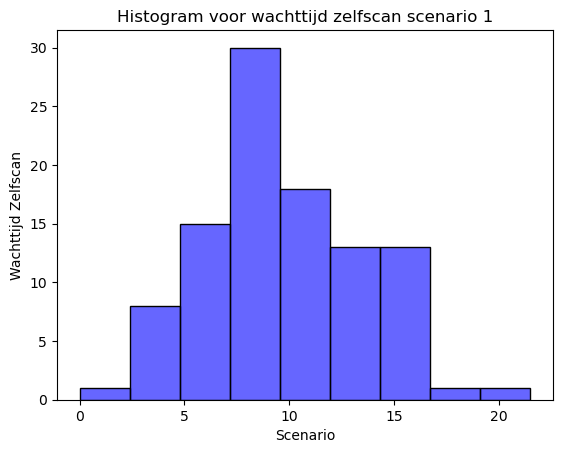

In [161]:
# Histogram maken van de wachttijd 
sns.histplot(df['wachttijd zelfscan'][df['scenario']==1], kde=False, color='blue', label='wachttijd zelfscan', alpha=0.6)
plt.xlabel("Scenario")
plt.ylabel("Wachttijd Zelfscan")
plt.title("Histogram voor wachttijd zelfscan scenario 1")
plt.show()

Je kunt bijvoorbeeld de kans bepalen dat de wachttijd van een klant of de gemiddelde wachttijd hoger is dan een bepaalde waarde. Je kunt het ook omdraaien en de grens berekenen waarbinnen 95% van de gevallen vallen.

In [162]:
# Met behulp van de quantile functie kun je het 95% percentiel bepalen
# Dat betekent dat in 95% van de gevallen de gemiddelde wachttijd lager is dan deze waarde
df.groupby('scenario')['wachttijd zelfscan'].quantile(0.95)

scenario
1    15.82
2    10.82
3     3.70
Name: wachttijd zelfscan, dtype: float64

Het plotten van een histogram en daarin een rechte lijn op de plek van het 95% percentiel zorgt voor een mooie visualisatie. 

Je zou ook een boxplot kunnen maken van een run om de gemiddelde wachttijd te plotten en de IQR methode kunnen gebruiken om te analyseren of er uitschieters zijn:

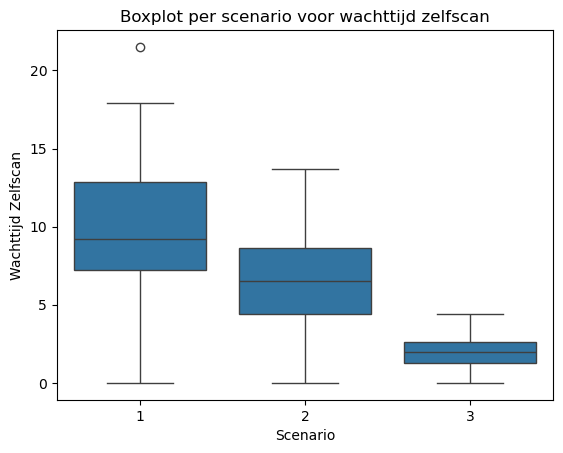

In [163]:
# Boxplot maken van de wachttijd waarbij de data gegroepeerd is per scenario
sns.boxplot(x="scenario", y="wachttijd zelfscan", data=df)
plt.xlabel("Scenario")
plt.ylabel("Wachttijd Zelfscan")
plt.title("Boxplot per scenario voor wachttijd zelfscan")
plt.show()

Het is daarnaast ook heel interessant om data van niveau 2 mee te nemen: de uitschieters qua wachttijden van individuele klanten of patiënten. Je kunt hier bijvoorbeeld het 95% percentiel bepalen van de wachttijd van alle klanten van alle runs van een scenario. Daarmee kun je ook weer bepalen hoe groot het risico is op uitschieters.

### Opdrachten supermarkt
**Opdracht 1.1.** Scenario's onderling vergelijken op gemiddelde én maximale wachttijd

Het doel van de eerste opdracht is om voor elk scenario de wachttijden van beide type kassa's onderling te vergelijken. 

Maak hiervoor een visualisatie om de scenario's onderling te kunnen vergelijken op de gemiddelde wachttijd én maximale wachttijd. Toon de gemiddelde wachttijd van alle runs en de maximale wachttijd van alle runs. Kies een passende visualisatie om de gemiddelde wachttijden van beide kassa's van alle scenario's te vergelijken en analyseer de resultaten.

In [164]:
# Voorbeeldcode om data op niveau 4 te genereren
df_level4 = df.groupby(['scenario']).agg({
    'wachttijd zelfscan': ['max', 'mean'],
    'wachttijd normaal': ['max', 'mean']})

df_level4

wachttijd zelfscan        wachttijd normaal        
                        max   mean               max    mean
scenario                                                    
1                      21.5  9.660              22.1   9.263
2                      13.7  6.418              42.1  12.717
3                       4.4  2.000              39.6  15.649

In [165]:
# Kolomnamen hernoemen
df_level4.columns = ['_'.join(col).strip() for col in df_level4.columns.values]
df_level4 = df_level4.reset_index()
df_level4


,scenario,wachttijd zelfscan_max,wachttijd zelfscan_mean,wachttijd normaal_max,wachttijd normaal_mean
0,1,21.5,9.660,22.1,9.263
1,2,13.7,6.418,42.1,12.717
2,3,4.4,2.000,39.6,15.649


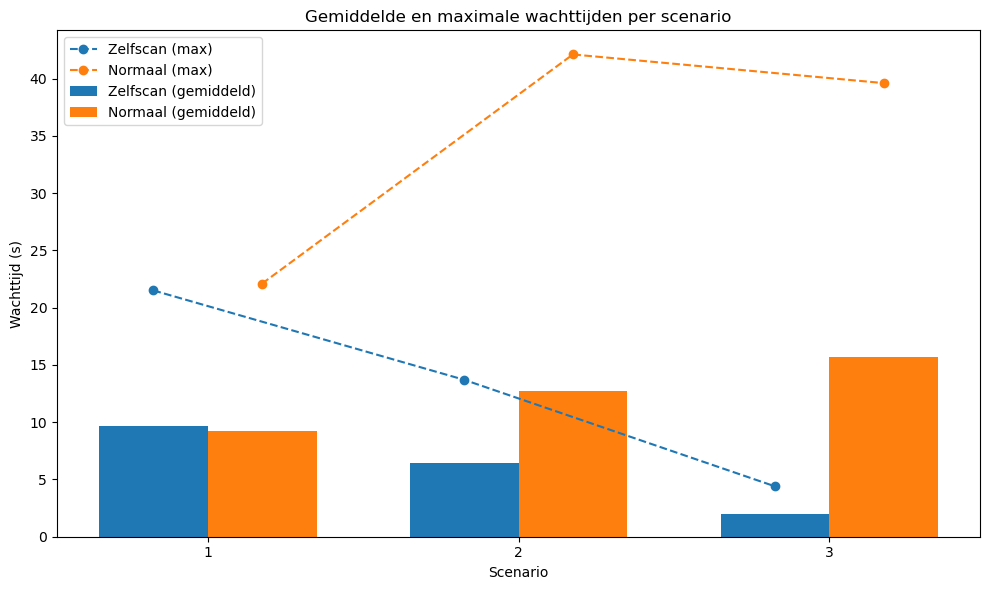

In [166]:
# X-as posities
x = np.arange(len(df_level4['scenario']))
width = 0.35  # breedte van de bars

fig, ax = plt.subplots(figsize=(10, 6))

# 1️⃣ Barplot voor gemiddelden
bars1 = ax.bar(x - width/2, df_level4['wachttijd zelfscan_mean'], width, label='Zelfscan (gemiddeld)')
bars2 = ax.bar(x + width/2, df_level4['wachttijd normaal_mean'], width, label='Normaal (gemiddeld)')

# 2️⃣ Lijnen voor maxima (met markers)
ax.plot(x - width/2, df_level4['wachttijd zelfscan_max'], color='tab:blue', marker='o', linestyle='--', label='Zelfscan (max)')
ax.plot(x + width/2, df_level4['wachttijd normaal_max'], color='tab:orange', marker='o', linestyle='--', label='Normaal (max)')

# 3️⃣ Opmaak
ax.set_xlabel('Scenario')
ax.set_ylabel('Wachttijd (s)')
ax.set_title('Gemiddelde en maximale wachttijden per scenario')
ax.set_xticks(x)
ax.set_xticklabels(df_level4['scenario'])
ax.legend()

plt.tight_layout()
plt.show()

**Opdracht 1.2.** Uitzonderingssituaties in kaart brengen

Het doel van de tweede opdracht is om de runs van elk scenario te analyseren. Wat valt er op qua minimale en maximale wachttijden? Zijn er runs waar iets *bijzonders* of *afwijkends* gebeurt? Is dat onwenselijk? 

Maak een visualisatie om de runs van elk scenario te analyseren. Kies passende visualisaties om te analyseren of er wenselijke of onwenselijke situaties zijn. 

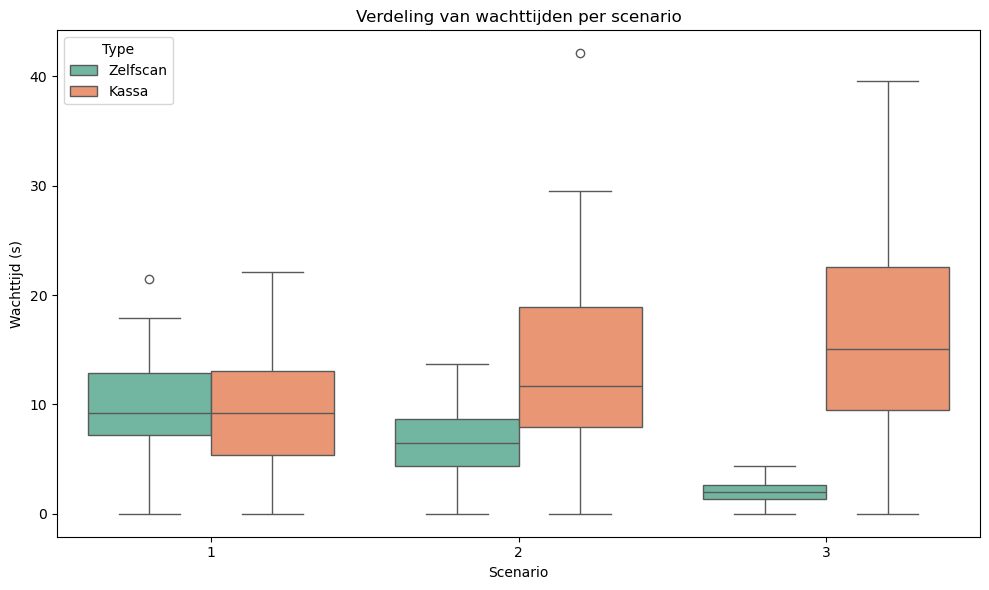

In [167]:
# Visualisatie 
df_long = df.melt(
    id_vars='scenario',
    value_vars=['wachttijd zelfscan', 'wachttijd normaal'],
    var_name='type',
    value_name='wachttijd'
)

# Mooiere labels (optioneel)
df_long['type'] = df_long['type'].replace({
    'wachttijd zelfscan': 'Zelfscan',
    'wachttijd normaal': 'Kassa'
})

# Plotten
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_long, x='scenario', y='wachttijd', hue='type', palette='Set2')

plt.title('Verdeling van wachttijden per scenario')
plt.xlabel('Scenario')
plt.ylabel('Wachttijd (s)')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

**Opdracht 1.3.** Bedrijfsbeslissing: optimaal aantal kassa's

De supermarkt wil uiteraard de kosten minimaliseren. Elke normale kassa heeft (uiteraard) één medewerker nodig, voor alle zelfscankassa's samen is er ook één medewerker nodig. 

Aan de andere kant mag de gemiddelde wachttijd niet te hoog zijn. Voor de normale kassa's mag de gemiddelde wachttijd maximaal 10 zijn en mogen er geen uitschieters boven de 25 zijn. Voor de zelfscan kassa's mag de gemiddelde wachttijd maximaal 5 zijn en mogen er geen uitschieters boven de 12 zijn.

Ga op zoek naar het optimale scenario en bepaal hoeveel medewerkers er nodig zijn. Pas daarvoor het codeblok met ```### Data genereren supermarkt``` aan, pas enkel onderstaande regels code aan:

```
scenario = [1, 2, 3] # aantal scenario's
zelfscan = [3, 6, 10] # aantal zelfscankassa's voor respectievelijk scenario 1, 2 en 3
normaal = [7, 3, 1] # aantal normale kassa's voor respectievelijk scenario 1, 2 en 3
```

Voor ```zelfscan``` en ```normaal``` kies je een aantal waardes, bijvoorbeeld ```zelfscan = [6, 8, 10, 12, 14]```. Zorg dat beide arrays even groot zijn en vul ```scenario``` dan met een opsomming van 1 tot en met het aantal ingevulde getallen. Bepaal daarna aan de hand van jouw visualisaties bij opdracht 1.1 en 1.2 wat het ideale scenario is.

In [177]:
# Uitwerking

# Parameters experiment
scenario = [1, 2, 3, 4, 5, 6, 7] # aantal scenario's
runs = 100 # aantal runs per scenario
zelfscan = [2, 4, 6, 8, 10, 12, 8] # aantal zelfscankassa's voor respectievelijk scenario 1, 2, ... n
normaal = [14, 12, 10, 8, 6, 4, 8] # aantal normale kassa's voor respectievelijk scenario 1, 2, ... n

# Lege lists om data op te slaan
scenario_list = []
run_list = []
zelfscan_list = []
normaal_list = []
wachttijd_zs = []
wachttijd_nor = []

# Synthetische data genereren
for sc in scenario:
    for run in range(1, runs + 1):

        # parameters vastleggen
        scenario_list.append(sc)
        run_list.append(run)
        zelfscan_list.append(zelfscan[scenario.index(sc)])
        normaal_list.append(normaal[scenario.index(sc)])

        # Wachttijd bij de zelfscankassa genereren:
        # normaal verdeling met gemiddelde 12 - aantal kassa's: hoe meer kassa's, hoe lager de wachttijd
        # en standaarddeviatie (12 - aantal kassa's) / 2: hoe meer kassa's, hoe lager de spreiding
        wachttijd_zs.append(np.random.normal(12-zelfscan[scenario.index(sc)], (12-zelfscan[scenario.index(sc)])/2))
        # Wachttijd bij de normale kassa genereren: 
        # normaal verdeling met gemiddelde 16 - aantal kassa's: wachttijd bij normale kassa's is hoger
        # en standaarddeviatie (16 - aantal kassa's) / 1.5: spreiding is nóg hoger, vandaar de 1.5
        wachttijd_nor.append(np.random.normal(16-normaal[scenario.index(sc)], (16-normaal[scenario.index(sc)])/1.5))

# Data opschonen: negatieve waardes vervangen met 0
wachttijd_zs = [x if x >= 0 else 0 for x in wachttijd_zs]
wachttijd_nor = [x if x >= 0 else 0 for x in wachttijd_nor]

# Dataframe genereren
df = pd.DataFrame({
    'scenario': scenario_list,
    'run': run_list,
    'zelfscan': zelfscan_list,
    'normaal': normaal_list,
    'wachttijd zelfscan': wachttijd_zs,
    'wachttijd normaal': wachttijd_nor
})

# Voorbeeldcode om data op niveau 4 te genereren
df_level4 = df.groupby(['scenario']).agg({
    'wachttijd zelfscan': ['mean', 'max'],
    'wachttijd normaal': ['mean', 'max']})

df_level4

wachttijd zelfscan            wachttijd normaal           
                       mean        max              mean        max
scenario                                                           
1                 10.035342  22.615556          1.962854   5.815996
2                  8.465779  15.328597          3.564911  11.998927
3                  6.158767  12.349040          6.436871  14.462500
4                  4.081063   9.942374          7.326554  18.993737
5                  2.013775   4.919594          9.102522  23.722923
6                  0.000000   0.000000         11.944084  31.928081
7                  4.090418   7.789833          8.069897  19.644570

Conclusie: er zijn zowel 8 zelfscan- als normale kassa's nodig. 

## Opdrachten ICU
In de repo staat een bestand ```icu_les4.yaml``` waarin generatoren voor synthetische data aangeroepen worden. Je kunt zelf deze inhoud in icu.yaml kopiëren en experimenten runnen, maar je mag ook de export van dit experiment (```icu - patient_timing - synth.csv``` en ```icu - icu - synth.csv```) gebruiken om analyses voor jouw portfolioitem uit te voeren.